## Step 1: Load the newsgroups data

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. You can find additional information here: 

In [4]:
from sklearn.datasets import fetch_20newsgroups

# You can load just a subset of categories for simplicity
categories = ['talk.religion.misc','alt.atheism','soc.religion.christian']

# Load the training data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

# Example of accessing the data
print(newsgroups_train.data[0])
print(newsgroups_train.target[0])  # Corresponding target to the above document

# The size of the dataset can be found by checking the length of the data list
print(f"Training set size: {len(newsgroups_train.data)}")

From: jayne@mmalt.guild.org (Jayne Kulikauskas)
Subject: Re: Can sin "block" our prayers?
Organization: Kulikauskas home
Lines: 27

mike@boulder.snsc.unr.edu (Mike McCormick) writes:

> Not honoring our wives can cause our prayers to be hindered:
> 
>         You husbands likewise, live with your wives in
>         an understanding way, as with a weaker vessel,
>         since she is a woman;  and grant her honor as
>         a fellow heir of the grace of life, so that your
>         prayers may not be hindered.  I Peter 3:7

One interpretation I've heard of this verse is that it refers to the sin 
of physically abusing one's wife.  The husband is usually physically 
stronger than his wife but is not permitted to use this to dominate her.  
He must honor her as his sister in Christ.  This would therefore be an 
example of a specific sin that blocks prayer.

This verse also makes me think of the kind of husband who decides what 
is God's will for his family without consulting his wife. 

## Step 2:  Vectorize our data

We need to turn our text into sets of words.  However, we don't want words that are either too frequent or infrequent.  To do this, we'll use the TF-IDF vectorizer, and pick the top N (up to you!) words.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Sample data
documents = newsgroups_train.data

# Initialize the TFIDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english")

# Fit the model and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

print(vectorizer)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each feature
# Here, we sum the scores for each term across all documents
sums = tfidf_matrix.sum(axis=0)

# Connecting term to its sums score
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0,col]))

# Create a DataFrame with the terms and their scores
ranking = pd.DataFrame(data, columns=['term','rank'])
ranking = ranking.sort_values('rank', ascending=False)

# Select top N terms
top_n = 1000
top_n_terms = ranking.head(top_n)
print(top_n_terms)

TfidfVectorizer(stop_words='english')
            term       rank
8230         edu  54.141299
10292        god  50.703659
5671         com  36.943917
16372     people  31.206464
12551      jesus  27.993130
...          ...        ...
8898    examples   2.508613
18289    related   2.506292
17433   prophets   2.501462
9648   followers   2.498626
8576    entirely   2.497467

[1000 rows x 2 columns]


## Step 3: Join your terms with the Glove Vectors

The GLOVE vectors are word embeddings produced by the Word2Vec network model.  You can find them at the [Stanford GloVe repository](https://nlp.stanford.edu/projects/glove/).  You'll probably want the smallest one (glove6b).  Once you have them, you'll need to map these vectors to your data - note that the vectors come in different sizes.  I'll use the 100 dimension vectors here for demonstration purposes. 

In [1]:
import numpy as np

# Load GloVe vectors into a dictionary:
glove_vectors = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector

In [10]:
original_feature_names = top_n_terms.term

#Note that not all features are present in the glove vectors, so we'll filter here:
word_vectors = []
filtered_feature_names = []

for word in original_feature_names:
    if word in glove_vectors:
        word_vectors.append(glove_vectors[word])
        filtered_feature_names.append(word)

# Convert the list of vectors to a numpy array
word_vectors = np.array(word_vectors)

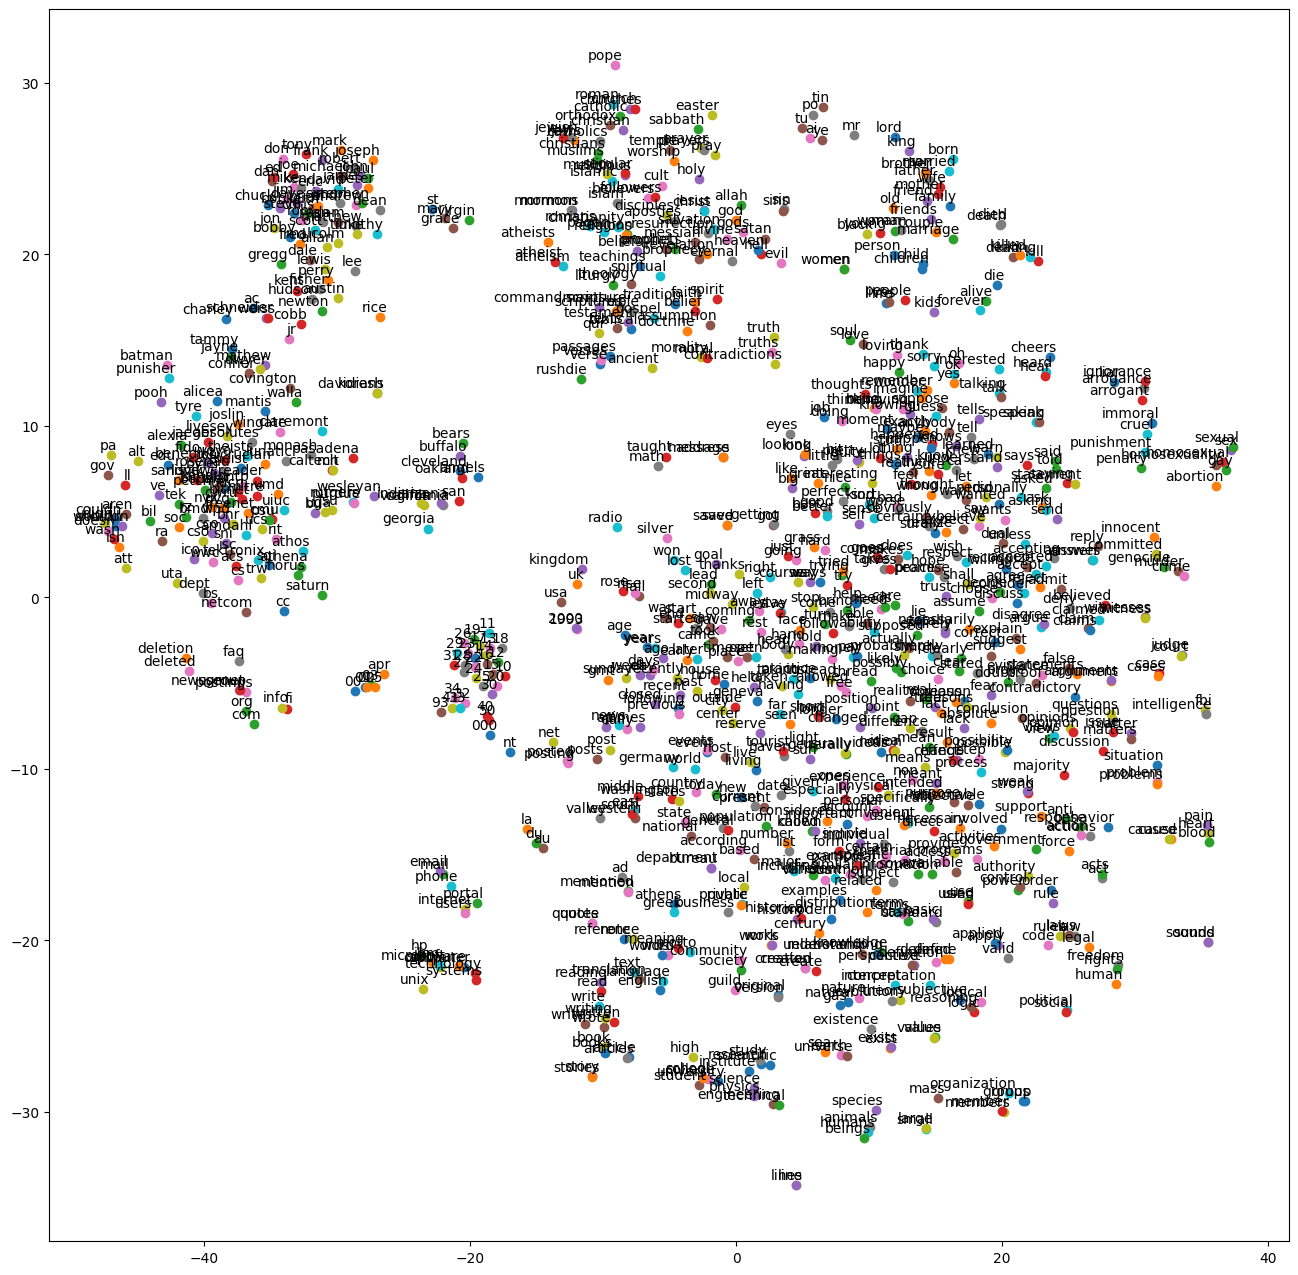

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use t-SNE to project the vectors into a 2D space
tsne = TSNE(n_components=2)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the projection
plt.figure(figsize=(16, 16))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:  # Only plot words that were in the GloVe vectors
        plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()